 Base code from https://github.com/tensorflow/models/tree/master/tutorials/rnn/translate.

In [1]:
import math, os, random, sys, time, logging
import numpy as np
import tensorflow as tf
import data_utils
from six.moves import xrange

### 1. Lectura de datos 


<b>Descripción:</b> Método para la lectura de los datos de origen y de destino (idioma de origen: Inglés, idioma de destino: Francés)

<b>Argumentos:</b>
>  <b>@source_path:</b> Ruta del archivo que contiene identificadores de tokens del idioma de origen.<br>
>  <b>@target_path:</b> Ruta del archivo que contiene identificadores de tokens del idioma de destino;<br>
>                debe haber una correspondencia entre el contenido del archivo de origen y destino : Por ejemplo<br>
>                la n-ésima línea del contenido del archivo de destino debe contener la salida deseada de la n-ésima<br>
>                línea del contenido del archivo de origen.<br>
>  <b>@max_size:</b>    Número máximo de líneas a leer, si toma el valor de 0 ó 'None' <br> 
>                se leerá todo el contenido de los archivos de datos.


<b>Retorna:</b>
>  <b>@data_set:</b> Una lista de longitud igual a la de la lista de buckets definida en la segunda celda (_buckets);<br>
>              data_set[n] contiene una lista de pares (origen, destino) leídas de los archivos de datos proporcionados <br>
>              (con rutas @source_path y @target_path) que encajan en el n-ésimo bucket tal que len(origen) < _buckets[n][0]<br>
>              y len(destino) < _buckets[n][1]; origen y destino son listas de identificadores de tokens.

In [3]:
def read_data(source_path, target_path, max_size=None):
    data_set = [[] for _ in _buckets]
    with tf.gfile.GFile(source_path, mode="r") as source_file:
        with tf.gfile.GFile(target_path, mode="r") as target_file:
            source, target = source_file.readline(), target_file.readline()
            counter = 0
            while source and target and (not max_size or counter < max_size):
                counter += 1
                if counter % 100000 == 0:
                    print("    reading data line %d" % counter)
                    sys.stdout.flush()
                source_ids = [int(x) for x in source.split()]
                target_ids = [int(x) for x in target.split()]
                target_ids.append(data_utils.EOS_ID)
                for bucket_id, (source_size, target_size) in enumerate(_buckets):
                    if len(source_ids) < source_size and len(target_ids) < target_size:
                        data_set[bucket_id].append([source_ids, target_ids])
                        break
                source, target = source_file.readline(), target_file.readline()
    return data_set

### 2. Creación del model 

<b>Descripción: </b> La clase Seq2SeqModel implementa una red neuronal recurrente multi-capa como codificador, y un
    decodificador basado en atención. Ésta clase implementa memoria de largo a corto plazo (LSTM en inglés), adicionalmente también 
    permite el uso de unidades recurrentes cerradas (GRU en inglés). También permite el uso de softmax muestreado para el manejo
    de un vocabulario de gran volumen

<b>Argumentos:</b>
>  <b>@from_vocab_size:</b> Tamaño del vocabulario en ingles.<br>
>  <b>@to_vocab_size:</b> Tamaño del vocabulario en frances.<br>
>  <b>@_buckets:</b> Duplas de buckets a usar en el preprocesamiento de la data (ingles, frances).<br>
>  <b>@size:</b> Tamaño de las capas del modelo. <br> 
>  <b>@num_layers:</b> Numero de capas. <br> 
>  <b>@max_gradient_norm:</b> maxima norma de las gradientes (regularizacion). <br>
>  <b>@batch_size:</b> Tamaño de los batch de entrenamiento. <br> 
>  <b>@learning_rate:</b> Ratio de aprendizaje. <br> 
>  <b>@learning_rate_decay_factor:</b> decaimiento del ratio de aprendizaje. <br> 
>  <b>@forward_only:</b> Si es verdadero. No se construye el paso hacia atrás en el modelo<br> 
>  <b>@dtype:</b> El tipo de datos que se usará para almacenar las variables internas, por ejemplo: tf.float32. <br>     

In [2]:
learning_rate = 0.5
learning_rate_decay_factor = 0.99
max_gradient_norm = 5.0
batch_size = 256
size = 512
num_layers = 2
from_vocab_size = 40000
to_vocab_size = 40000
data_dir = 'results'
train_dir = 'train'
max_train_data_size = 6500000
steps_per_checkpoint = 100
use_fp16 = False
# Archivos de vocabulario:
# from_train_data = None
# to_train_data = None
# from_dev_data = None
# to_dev_data = None

# Duplas de buckets a usar en el preprocesamiento de la data (ingles, frances).
_buckets = [(5, 10), (10, 15), (20, 25), (40, 50)]

In [4]:
def create_model(session, forward_only):
    """Create translation model and initialize or load parameters in session."""
    dtype = tf.float16 if use_fp16 else tf.float32
    model = Seq2SeqModel(
        from_vocab_size,
        to_vocab_size,
        _buckets,
        size,
        num_layers,
        max_gradient_norm,
        batch_size,
        learning_rate,
        learning_rate_decay_factor,
        forward_only=forward_only,
        dtype=dtype)
    ckpt = tf.train.get_checkpoint_state(train_dir)
    if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
        print("Reading model parameters from %s" % ckpt.model_checkpoint_path)
        model.saver.restore(session, ckpt.model_checkpoint_path)
    else:
        print("Created model with fresh parameters.")
        session.run(tf.global_variables_initializer())
    return model

### 3. Detalle del modelo 
El modelo esta basado en [Grammar as a Foreign Language](http://arxiv.org/abs/1412.7449).
El modelo se basa en usar un Encoder para traducir una secuencia de inputs, en este caso una secuencia de embeddings de palabras, en un solo vector, para luego usar un Decoder que en base al vector retorna una secuencia de outputs.

Este modelo utiliza tambien un modelo de atencion, el cual en cada paso del Decoder, evalua la importancia que debe darle a cada objeto en la secuencia de entrada.

<img src="seq2seqatt.png" alt="" style="width: 350px;"/>

In [ ]:
class Seq2SeqModel(object):
    def __init__(self,
                 source_vocab_size,
                 target_vocab_size,
                 buckets,
                 size,
                 num_layers,
                 max_gradient_norm,
                 batch_size,
                 learning_rate,
                 learning_rate_decay_factor,
                 use_lstm=False,
                 num_samples=512,
                 forward_only=False,
                 dtype=tf.float32):
        
        self.source_vocab_size = source_vocab_size
        self.target_vocab_size = target_vocab_size
        self.buckets = buckets
        self.batch_size = batch_size
        self.learning_rate = tf.Variable(
                float(learning_rate), trainable=False, dtype=dtype)
        self.learning_rate_decay_op = self.learning_rate.assign(
                self.learning_rate * learning_rate_decay_factor)
        self.global_step = tf.Variable(0, trainable=False)
        
        # En caso se use sampled softmax (http://arxiv.org/abs/1412.2007), se crean
        # las variables de acuerdo al tamaño del vocabulario y el numero de ejemplos
        # (target_vocab_size, num_samples). Si el numero de ejemplos es menor que el
        # tamaño del vocabulario, no es necesario hacer este sampling.
        output_projection = None
        softmax_loss_function = None
        if num_samples > 0 and num_samples < self.target_vocab_size:
            w_t = tf.get_variable("proj_w", [self.target_vocab_size, size], dtype=dtype)
            w = tf.transpose(w_t)
            b = tf.get_variable("proj_b", [self.target_vocab_size], dtype=dtype)
            output_projection = (w, b)

            def sampled_loss(labels, logits):
                labels = tf.reshape(labels, [-1, 1])
                local_w_t = tf.cast(w_t, tf.float32)
                local_b = tf.cast(b, tf.float32)
                local_inputs = tf.cast(logits, tf.float32)
                return tf.cast(
                        tf.nn.sampled_softmax_loss(
                                weights=local_w_t,
                                biases=local_b,
                                labels=labels,
                                inputs=local_inputs,
                                num_sampled=num_samples,
                                num_classes=self.target_vocab_size),
                        dtype)
            softmax_loss_function = sampled_loss

            
        # Se crea la capa RNN de acuerdo a los parametros especificados, estas puede
        # utilizar celdas LSTM o GRU. Tambien se define el tamaño de la red (num_layers).
        def single_cell():
            return tf.contrib.rnn.GRUCell(size)
        if use_lstm:
            def single_cell():
                return tf.contrib.rnn.BasicLSTMCell(size)
        cell = single_cell()
        if num_layers > 1:
            cell = tf.contrib.rnn.MultiRNNCell([single_cell() for _ in range(num_layers)])

        # Se usa el wrapper de tensorflow para generar un modelo seq2seq
        def seq2seq_f(encoder_inputs, decoder_inputs, do_decode):
            return tf.contrib.legacy_seq2seq.embedding_attention_seq2seq(
                    encoder_inputs,
                    decoder_inputs,
                    cell,
                    num_encoder_symbols=source_vocab_size,
                    num_decoder_symbols=target_vocab_size,
                    embedding_size=size,
                    output_projection=output_projection,
                    feed_previous=do_decode,
                    dtype=dtype)

        # Se alimentan los inputs del modelo
        self.encoder_inputs = []
        self.decoder_inputs = []
        self.target_weights = []
        for i in xrange(buckets[-1][0]):
            self.encoder_inputs.append(tf.placeholder(tf.int32, shape=[None],
                                                      name="encoder{0}".format(i)))
        for i in xrange(buckets[-1][1] + 1):
            self.decoder_inputs.append(tf.placeholder(tf.int32, shape=[None],
                                                      name="decoder{0}".format(i)))
            self.target_weights.append(tf.placeholder(dtype, shape=[None],
                                                      name="weight{0}".format(i)))

        # El target del modelo son los inputs del decoder, en una posicion 
        # adelantada en cada paso.
        targets = [self.decoder_inputs[i + 1]
                             for i in xrange(len(self.decoder_inputs) - 1)]

        # Se almacenan las salidas y el resultado de la funcion de perdida.
        if forward_only:
            self.outputs, self.losses = tf.contrib.legacy_seq2seq.model_with_buckets(
                    self.encoder_inputs, self.decoder_inputs, targets,
                    self.target_weights, buckets, lambda x, y: seq2seq_f(x, y, True),
                    softmax_loss_function=softmax_loss_function)

            if output_projection is not None:
                for b in xrange(len(buckets)):
                    self.outputs[b] = [
                            tf.matmul(output, output_projection[0]) + output_projection[1]
                            for output in self.outputs[b]
                    ]
        else:
            self.outputs, self.losses = tf.contrib.legacy_seq2seq.model_with_buckets(
                    self.encoder_inputs, self.decoder_inputs, targets,
                    self.target_weights, buckets,
                    lambda x, y: seq2seq_f(x, y, False),
                    softmax_loss_function=softmax_loss_function)

        # Se calculan las gradientes y la funcion de optimizacion del modelo (SGD).
        params = tf.trainable_variables()
        if not forward_only:
            self.gradient_norms = []
            self.updates = []
            opt = tf.train.GradientDescentOptimizer(self.learning_rate)
            for b in xrange(len(buckets)):
                gradients = tf.gradients(self.losses[b], params)
                clipped_gradients, norm = tf.clip_by_global_norm(gradients, max_gradient_norm)
                self.gradient_norms.append(norm)
                self.updates.append(opt.apply_gradients(
                        zip(clipped_gradients, params), global_step=self.global_step))

        self.saver = tf.train.Saver(tf.global_variables())

    def step(self, session, encoder_inputs, decoder_inputs, target_weights,
                     bucket_id, forward_only):
        """Run a step of the model feeding the given inputs.
         Returns:
            A triple consisting of gradient norm (or None if we did not do backward),
            average perplexity, and the outputs.
        """
        # Validaciones.
        encoder_size, decoder_size = self.buckets[bucket_id]
        if len(encoder_inputs) != encoder_size:
            raise ValueError("Encoder length must be equal to the one in bucket,"
                                             " %d != %d." % (len(encoder_inputs), encoder_size))
        if len(decoder_inputs) != decoder_size:
            raise ValueError("Decoder length must be equal to the one in bucket,"
                                             " %d != %d." % (len(decoder_inputs), decoder_size))
        if len(target_weights) != decoder_size:
            raise ValueError("Weights length must be equal to the one in bucket,"
                                             " %d != %d." % (len(target_weights), decoder_size))
        # Se construye el input de la funcion.
        input_feed = {}
        for l in xrange(encoder_size):
            input_feed[self.encoder_inputs[l].name] = encoder_inputs[l]
        for l in xrange(decoder_size):
            input_feed[self.decoder_inputs[l].name] = decoder_inputs[l]
            input_feed[self.target_weights[l].name] = target_weights[l]

        last_target = self.decoder_inputs[decoder_size].name
        input_feed[last_target] = np.zeros([self.batch_size], dtype=np.int32)

        # Se construye el output de la funcion, se calculan las gradientes solo
        # si en caso de entrenar la red.
        if not forward_only:
            output_feed = [self.updates[bucket_id],    # Update Op that does SGD.
                                         self.gradient_norms[bucket_id],    # Gradient norm.
                                         self.losses[bucket_id]]    # Loss for this batch.
        else:
            output_feed = [self.losses[bucket_id]]    # Loss for this batch.
            for l in xrange(decoder_size):    # Output logits.
                output_feed.append(self.outputs[bucket_id][l])

        outputs = session.run(output_feed, input_feed)
        if not forward_only:
            return outputs[1], outputs[2], None    # Gradient norm, loss, no outputs.
        else:
            return None, outputs[0], outputs[1:]    # No gradient norm, loss, outputs.

    def get_batch(self, data, bucket_id):
        """Get a random batch of data from the specified bucket, prepare for step.
        To feed data in step(..) it must be a list of batch-major vectors, while
        data here contains single length-major cases. So the main logic of this
        function is to re-index data cases to be in the proper format for feeding.
        Args:
            data: a tuple of size len(self.buckets) in which each element contains
                lists of pairs of input and output data that we use to create a batch.
            bucket_id: integer, which bucket to get the batch for.
        Returns:
            The triple (encoder_inputs, decoder_inputs, target_weights) for
            the constructed batch that has the proper format to call step(...) later.
        """
        encoder_size, decoder_size = self.buckets[bucket_id]
        encoder_inputs, decoder_inputs = [], []

        # Get a random batch of encoder and decoder inputs from data,
        # pad them if needed, reverse encoder inputs and add GO to decoder.
        for _ in xrange(self.batch_size):
            encoder_input, decoder_input = random.choice(data[bucket_id])

            # Encoder inputs are padded and then reversed.
            encoder_pad = [data_utils.PAD_ID] * (encoder_size - len(encoder_input))
            encoder_inputs.append(list(reversed(encoder_input + encoder_pad)))

            # Decoder inputs get an extra "GO" symbol, and are padded then.
            decoder_pad_size = decoder_size - len(decoder_input) - 1
            decoder_inputs.append([data_utils.GO_ID] + decoder_input +
                                                        [data_utils.PAD_ID] * decoder_pad_size)

        # Now we create batch-major vectors from the data selected above.
        batch_encoder_inputs, batch_decoder_inputs, batch_weights = [], [], []

        # Batch encoder inputs are just re-indexed encoder_inputs.
        for length_idx in xrange(encoder_size):
            batch_encoder_inputs.append(
                    np.array([encoder_inputs[batch_idx][length_idx]
                                        for batch_idx in xrange(self.batch_size)], dtype=np.int32))

        # Batch decoder inputs are re-indexed decoder_inputs, we create weights.
        for length_idx in xrange(decoder_size):
            batch_decoder_inputs.append(
                    np.array([decoder_inputs[batch_idx][length_idx]
                                        for batch_idx in xrange(self.batch_size)], dtype=np.int32))

            # Create target_weights to be 0 for targets that are padding.
            batch_weight = np.ones(self.batch_size, dtype=np.float32)
            for batch_idx in xrange(self.batch_size):
                # We set weight to 0 if the corresponding target is a PAD symbol.
                # The corresponding target is decoder_input shifted by 1 forward.
                if length_idx < decoder_size - 1:
                    target = decoder_inputs[batch_idx][length_idx + 1]
                if length_idx == decoder_size - 1 or target == data_utils.PAD_ID:
                    batch_weight[batch_idx] = 0.0
            batch_weights.append(batch_weight)
        return batch_encoder_inputs, batch_decoder_inputs, batch_weights


### 4. Entrenamiento 

<b>Descripción: </b> Entrena el modelo de traduccion de ingles a frances usando el dataset WMT.<br>
Los comentarios se encuentran a lo largo del cuerpo del método train()

In [3]:
def train():
    """Entrena el modelo de traduccion de ingles a frances usando el dataset WMT."""
    if from_train_data and to_train_data:
        # Carga la data del dataset WMT.
        from_train, to_train, from_dev, to_dev, _, _ = data_utils.prepare_data(
            data_dir,
            from_train_data, to_train_data,
            from_dev_data, to_dev_data,
            from_vocab_size, to_vocab_size)
    else:
        # Prepara la data del dataset WMT.
        print("Preparing WMT data in %s" % data_dir)
        from_train, to_train, from_dev, to_dev, _, _ = data_utils.prepare_wmt_data(
            data_dir, from_vocab_size, to_vocab_size)

    with tf.Session() as sess:
        # Crea el modelo.
        print("Creating %d layers of %d units." % (num_layers, size))
        model = create_model(sess, False)

        # Lee la data en buckets y computa sus tamaños.
        print ("Reading development and training data (limit: %d)."
                 % max_train_data_size)
        dev_set = read_data(from_dev, to_dev)
        train_set = read_data(from_train, to_train, max_train_data_size)
        train_bucket_sizes = [len(train_set[b]) for b in xrange(len(_buckets))]
        train_total_size = float(sum(train_bucket_sizes))

        # El bucket scale es una lista de numeros incrementales de 0 a 1 que se usa
        # para seleccionar un bucket especifico. El tamaño de [scale[i], scale[i+1]]
        # es proporcional al tamaño del bucket i.
        train_buckets_scale = [sum(train_bucket_sizes[:i + 1]) / train_total_size
                                 for i in xrange(len(train_bucket_sizes))]

        # Loop de entrenamiento.
        step_time, loss = 0.0, 0.0
        current_step = 0
        previous_losses = []
        while True:
            # Se escoge un bucket de acuerdo a la distribucion de la data. Se escoge
            # un numero random entre [0, 1] y se usa el correspondiente intervalo en
            # train_buckets_scale.
            random_number_01 = np.random.random_sample()
            bucket_id = min([i for i in xrange(len(train_buckets_scale))
                             if train_buckets_scale[i] > random_number_01])

            # Obtener un batch y hacer un step de entrenamiento.
            start_time = time.time()
            encoder_inputs, decoder_inputs, target_weights = model.get_batch(
                train_set, bucket_id)
            _, step_loss, _ = model.step(sess, encoder_inputs, decoder_inputs,
                                         target_weights, bucket_id, False)
            step_time += (time.time() - start_time) / steps_per_checkpoint
            loss += step_loss / steps_per_checkpoint
            current_step += 1

            # Cada cierto numero de pasos, se guarda un checkpoint, se muestran
            # las estadisticas y se ejecutan evaluaciones.
            if current_step % steps_per_checkpoint == 0:
                # Muestra las estadisticas del epoch previo.
                perplexity = math.exp(float(loss)) if loss < 300 else float("inf")
                print ("global step %d learning rate %.4f step-time %.2f perplexity "
                         "%.2f" % (model.global_step.eval(), model.learning_rate.eval(),
                                 step_time, perplexity))
                # Log de entrenamiento
                with open('log/train.txt', 'a') as f:
                    f.writelines('%.6f, %.6f\n' % (loss, perplexity))
                
                # Disminuye el learning rate si no hubo mejoras en el entrenamiento las
                # ultimas 3 epocas.
                if len(previous_losses) > 2 and loss > max(previous_losses[-3:]):
                    sess.run(model.learning_rate_decay_op)
                previous_losses.append(loss)
                # Se guarda un checkpoint.
                checkpoint_path = os.path.join(train_dir, "translate.ckpt")
                model.saver.save(sess, checkpoint_path, global_step=model.global_step)
                step_time, loss = 0.0, 0.0
                # Se ejecutan las evaluaciones en el development set y se imprime la
                # perplejidad.
                for bucket_id in xrange(len(_buckets)):
                    if len(dev_set[bucket_id]) == 0:
                        print("    eval: empty bucket %d" % (bucket_id))
                        continue
                    encoder_inputs, decoder_inputs, target_weights = model.get_batch(
                        dev_set, bucket_id)
                    _, eval_loss, _ = model.step(sess, encoder_inputs, decoder_inputs,
                                                 target_weights, bucket_id, True)
                    eval_ppx = math.exp(float(eval_loss)) if eval_loss < 300 else float(
                        "inf")
                    print("    eval: bucket %d perplexity %.2f" % (bucket_id, eval_ppx))
                    
                    with open('log/test.txt', 'a') as f:
                        f.writelines('%d, %.6f, %.6f\n' % (bucket_id, eval_loss, eval_ppx))


### 5. Decodificación 

<b>Descripción: </b> Carga y utiliza el modelo entrenado para traducir oraciones en inglés a francés. <br>
    Los comentarios están en el cuerpo del método.

In [6]:
def decode():
    with tf.Session() as sess:
        # Crea el modelo y carga los parametros.
        model = create_model(sess, True)
        model.batch_size = 1    # Se decodea una palabra a la vez.

        # Carga vocabularios en memoria.
        en_vocab_path = os.path.join(data_dir,
                                     "vocab%d.from" % from_vocab_size)
        fr_vocab_path = os.path.join(data_dir,
                                     "vocab%d.to" % to_vocab_size)
        en_vocab, _ = data_utils.initialize_vocabulary(en_vocab_path)
        _, rev_fr_vocab = data_utils.initialize_vocabulary(fr_vocab_path)

        # Lee texto del usuario.
        sentence = input('> ')
        while sentence:
            # Obtiene el token id de la oracion.
            token_ids = data_utils.sentence_to_token_ids(tf.compat.as_bytes(sentence), en_vocab)
            # Asigna la oracion a un bucket adecuado.
            bucket_id = len(_buckets) - 1
            for i, bucket in enumerate(_buckets):
                if bucket[0] >= len(token_ids):
                    bucket_id = i
                    break
            else:
                logging.warning("Sentence truncated: %s", sentence)

            # Crea un batch con la primera palabra.
            encoder_inputs, decoder_inputs, target_weights = model.get_batch(
                {bucket_id: [(token_ids, [])]}, bucket_id)
            # Obtiene los resultados del modelo (softmax).
            _, _, output_logits = model.step(sess, encoder_inputs, decoder_inputs,
                                             target_weights, bucket_id, True)
            # Se asigna como output el resultado con mayor valor (argmax).
            outputs = [int(np.argmax(logit, axis=1)) for logit in output_logits]
            # En caso de un token 'EOS' (end of sentence), se termina la traduccion.
            if data_utils.EOS_ID in outputs:
                outputs = outputs[:outputs.index(data_utils.EOS_ID)]
            # Muestra el resultado final.
            print(" ".join([tf.compat.as_str(rev_fr_vocab[output]) for output in outputs]))
            sys.stdout.flush()
            sentence = input('> ')

### 6. Entrenamiento de la red

In [ ]:
train()

Preparing WMT data in results
Successfully downloaded training-giga-fren.tar 2595102720 bytes
Extracting tar file results/training-giga-fren.tar
Unpacking results/giga-fren.release2.fixed.fr.gz to results/giga-fren.release2.fixed.fr
Unpacking results/giga-fren.release2.fixed.en.gz to results/giga-fren.release2.fixed.en
Successfully downloaded dev-v2.tgz 21393583 bytes
Extracting tgz file results/dev-v2.tgz
Creating vocabulary results/vocab40000.to from data results/giga-fren.release2.fixed.fr
  processing line 100000
  processing line 200000
  processing line 300000
  processing line 400000
  processing line 500000
  processing line 600000
  processing line 700000
  processing line 800000
  processing line 900000
  processing line 1000000
  processing line 1100000
  processing line 1200000
  processing line 1300000
  processing line 1400000
  processing line 1500000
  processing line 1600000
  processing line 1700000
  processing line 1800000
  processing line 1900000
  processing line

  processing line 5800000
  processing line 5900000
  processing line 6000000
  processing line 6100000
  processing line 6200000
  processing line 6300000
  processing line 6400000
  processing line 6500000
  processing line 6600000
  processing line 6700000
  processing line 6800000
  processing line 6900000
  processing line 7000000
  processing line 7100000
  processing line 7200000
  processing line 7300000
  processing line 7400000
  processing line 7500000
  processing line 7600000
  processing line 7700000
  processing line 7800000
  processing line 7900000
  processing line 8000000
  processing line 8100000
  processing line 8200000
  processing line 8300000
  processing line 8400000
  processing line 8500000
  processing line 8600000
  processing line 8700000
  processing line 8800000
  processing line 8900000
  processing line 9000000
  processing line 9100000
  processing line 9200000
  processing line 9300000
  processing line 9400000
  processing line 9500000
  processing

  tokenizing line 14000000
  tokenizing line 14100000
  tokenizing line 14200000
  tokenizing line 14300000
  tokenizing line 14400000
  tokenizing line 14500000
  tokenizing line 14600000
  tokenizing line 14700000
  tokenizing line 14800000
  tokenizing line 14900000
  tokenizing line 15000000
  tokenizing line 15100000
  tokenizing line 15200000
  tokenizing line 15300000
  tokenizing line 15400000
  tokenizing line 15500000
  tokenizing line 15600000
  tokenizing line 15700000
  tokenizing line 15800000
  tokenizing line 15900000
  tokenizing line 16000000
  tokenizing line 16100000
  tokenizing line 16200000
  tokenizing line 16300000
  tokenizing line 16400000
  tokenizing line 16500000
  tokenizing line 16600000
  tokenizing line 16700000
  tokenizing line 16800000
  tokenizing line 16900000
  tokenizing line 17000000
  tokenizing line 17100000
  tokenizing line 17200000
  tokenizing line 17300000
  tokenizing line 17400000
  tokenizing line 17500000
  tokenizing line 17600000
 

  tokenizing line 22100000
  tokenizing line 22200000
  tokenizing line 22300000
  tokenizing line 22400000
  tokenizing line 22500000
Tokenizing data in results/newstest2013.fr
Tokenizing data in results/newstest2013.en
Creating 3 layers of 1024 units.
Created model with fresh parameters.
Reading development and training data (limit: 0).
    reading data line 100000
    reading data line 200000
    reading data line 300000
    reading data line 400000
    reading data line 500000
    reading data line 600000
    reading data line 700000
    reading data line 800000
    reading data line 900000
    reading data line 1000000
    reading data line 1100000
    reading data line 1200000
    reading data line 1300000
    reading data line 1400000
    reading data line 1500000
    reading data line 1600000
    reading data line 1700000
    reading data line 1800000
    reading data line 1900000
    reading data line 2000000
    reading data line 2100000
    reading data line 2200000
    read

### 7. Gráficos para mostrar la evolución de la función de pérdida y perplejidad

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Training log:
Final loss=2.101810, final perplexity=8.180967


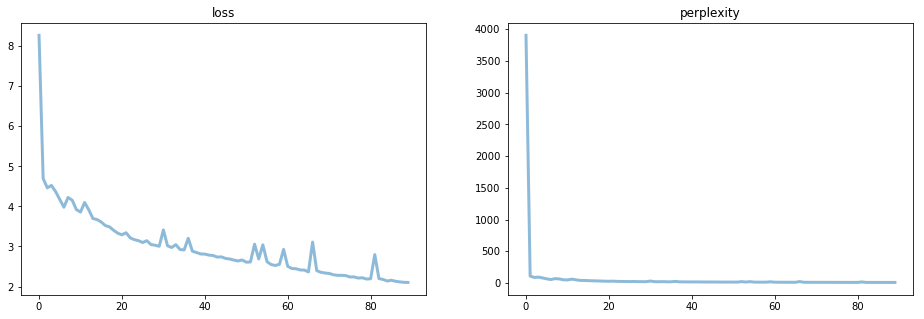

Evaluation log:
Bucket 0: loss=2.082066, ppx=8.021022 (eng_size:05, fr_size:10)
Bucket 1: loss=2.021780, ppx=7.551755 (eng_size:10, fr_size:15)
Bucket 2: loss=2.221751, ppx=9.223467 (eng_size:20, fr_size:25)
Bucket 3: loss=2.276136, ppx=9.738978 (eng_size:40, fr_size:50)
Avg loss=2.150433, Avg ppx=8.633806


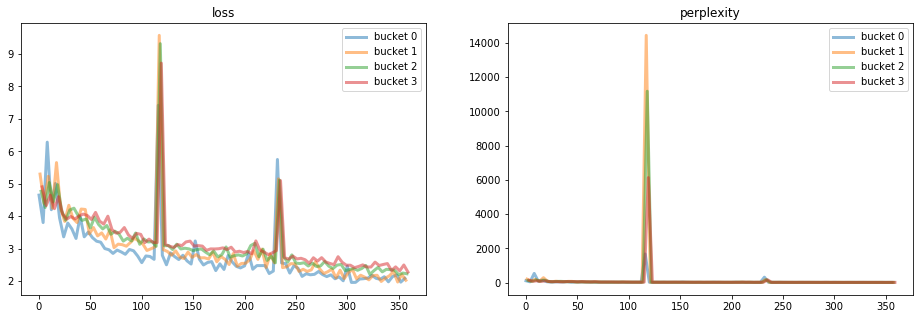

In [8]:
train_log = pd.read_csv('log/train.txt', names=['loss', 'perplexity'])
fig, ax = plt.subplots(ncols=2, figsize=(16,5))
ax[0].set_title('loss')
ax[1].set_title('perplexity')
ax[0].plot(train_log['loss'], alpha=.5, linewidth=3)
ax[1].plot(train_log['perplexity'], alpha=.5, linewidth=3)
print('Training log:')
print('Final loss=%f, final perplexity=%f' %
      (train_log['loss'].values[-1],
       train_log['perplexity'].values[-1]))
plt.show()

test_log = pd.read_csv('log/test.txt', index_col=False, names=['bucket_id', 'eval_loss', 'eval_ppx'])
fig, ax = plt.subplots(ncols=2, figsize=(16,5))
ax[0].set_title('loss')
ax[1].set_title('perplexity')

for b in test_log.bucket_id.unique():
    ax[0].plot(test_log[test_log.bucket_id == b]['eval_loss'], label=f'bucket {b}', alpha=.5, linewidth=3)
    ax[1].plot(test_log[test_log.bucket_id == b]['eval_ppx'], label=f'bucket {b}', alpha=.5, linewidth=3)

for a in ax: a.legend()
print('Evaluation log:')

for i, bs in enumerate(_buckets):
    print(f'Bucket {i}: loss=%f, ppx=%f (eng_size:{bs[0]:02}, fr_size:{bs[1]})' %
          (test_log['eval_loss'].values[i-4], test_log['eval_ppx'].values[i-4]))

print('Avg loss=%f, Avg ppx=%f' %
      (np.mean(test_log['eval_loss'].values[-4:]),
       np.mean(test_log['eval_ppx'].values[-4:])))
    
# _buckets = [(5, 10), (10, 15), (20, 25), (40, 50)]
plt.show()

### 8. Probando la red entrenada

In [7]:
decode()

Reading model parameters from train/translate.ckpt-18900
> This is great.
Ce sont les résultats .
> My name is tensorflow.
Ce nom est _UNK .
> What is your name?
Ce nom est le nom ?
> I am trained to translate from english to french.
Les participants se _UNK à les _UNK à les _UNK .
> There are many words I don't know yet.
Il y existe que je ne _UNK pas .


KeyboardInterrupt: 